# ManualAIze development

In [4]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [5]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

In [6]:
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")


In [7]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"Certification - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

## Let's start building the agent

This agent main goal is to parse and retrieve information from user manuals uploaded by the user. The first step will always be retrieval potentially augmented by internet searches. The outile of the agentic loop is the following

1. User uploads pdfs 
2. User inputs a question
3. Agent cycle starts
    - a. retrieve most relevant information from the uploaded pdfs
    - b. router agent evaluates if there is enough context
        - i. if not, calls tavily search
    - c. once it has enough context calls the writer node

### Set up the retrieval node
Let's start with parsing, embedding and storing the pdfs using Qdrant

In [8]:
import glob
import time
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Get all PDF files in the data directory
pdf_files = glob.glob("./data/*.pdf")
print(f"Found {len(pdf_files)} PDF files:")
for file in pdf_files:
    print(f"  - {file}")

# Load all PDF files with PyPDF (much faster!)
all_documents_pypdf = []
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

for pdf_file in pdf_files:
    try:
        print(f"\nLoading {pdf_file}...")
        start_time = time.time()
        
        # PyPDFLoader is MUCH faster than UnstructuredPDFLoader
        loader = PyPDFLoader(pdf_file)
        pages = loader.load()
        
        # Split into smaller chunks for better retrieval
        documents = text_splitter.split_documents(pages)
        
        elapsed = time.time() - start_time
        all_documents_pypdf.extend(documents)
        print(f"✓ Loaded {len(pages)} pages → {len(documents)} chunks in {elapsed:.1f}s")
        
    except Exception as e:
        print(f"✗ Error loading {pdf_file}: {e}")

print(f"\nTotal documents: {len(all_documents_pypdf)}")

Found 3 PDF files:
  - ./data/2024-odyssey.pdf
  - ./data/foonf_2024_manual_US_EN_02_27_2024_WEB_Final.pdf
  - ./data/2022-mazda-mazda6.pdf

Loading ./data/2024-odyssey.pdf...
✓ Loaded 702 pages → 1210 chunks in 29.7s

Loading ./data/foonf_2024_manual_US_EN_02_27_2024_WEB_Final.pdf...
✓ Loaded 100 pages → 143 chunks in 4.0s

Loading ./data/2022-mazda-mazda6.pdf...
✓ Loaded 702 pages → 1466 chunks in 12.0s

Total documents: 2819


In [9]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    all_documents_pypdf,
    embeddings,
    location=":memory:",
    collection_name="Manuals"
)

### Now let's create the retrieval node

This is not RAG. I want this node to just fetch the information

In [11]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

compressor = CohereRerank(model="rerank-v3.5")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

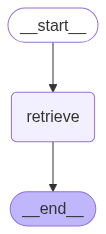

In [31]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

class State(TypedDict):
    question: str
    context: list[Document]  # From retrieval node
    internet_context: list[Document]   # From search if needed
    evaluation_result: str             # Decision from evaluator
    response: str  

def retrieve(state: State) -> State:
    retrieved_docs = compression_retriever.invoke(state["question"])
    return {"context": retrieved_docs}

graph_builder = StateGraph(State)
graph_builder = graph_builder.add_sequence([retrieve])
graph_builder.add_edge(START, "retrieve")
retrieval_graph = graph_builder.compile()

retrieval_graph

In [32]:
retrieval_graph.invoke({"question" : "What are the front facing height and weight limits for the car seat?"})

{'question': 'What are the front facing height and weight limits for the car seat?',
 'context': [Document(metadata={'producer': 'Adobe PDF Library 15.0', 'creator': 'Adobe InDesign CC 2017 (Windows)', 'creationdate': '2024-02-27T10:43:44-05:00', 'moddate': '2024-02-28T00:09:55-05:00', 'trapped': '/False', 'source': './data/foonf_2024_manual_US_EN_02_27_2024_WEB_Final.pdf', 'total_pages': 100, 'page': 17, 'page_label': '15', '_id': '70b5ad69b53c447f81a3900f24f5d1b9', '_collection_name': 'Manuals', 'relevance_score': 0.75312227}, page_content='15\n  When Using This Car Seat \nin Forward-Facing Mode\nP Child’s weight is between 22 and 65 lb \n(10 and 29.5 kg).\nP Child’s height is between 30 and 49 in. \n(76 and 124 cm).\nP Child is at least 1 year of age.\nP Car seat is securely installed in a rear \nvehicle seating position using either the \nrigid LATCH Connectors and the Top \nTether; the vehicle belt and Top Tether; or \nthe rigid LATCH Connectors, the vehicle \nbelt, and the Top Te

### Helper functions
Now I am going to create helper functions to help me quickly build the nodes, the graph and the connections between them.We will have our helper accepts the following parameters:


- llm: the llm that will power this agent node
- tools: the list of tools available to the llm
- system_prompt: the system prompt to attach to the llm to ground its generation

In [33]:
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph

In [34]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    
    # Extract the actual output text from the agent result
    if isinstance(result, dict):
        output_text = result.get('output', str(result))
    else:
        output_text = str(result)
    
    # Return two messages: one identifying the agent, one with its response
    return {
        "messages": [
            HumanMessage(content=f"{name} agent responding:"),
            AIMessage(content=output_text, name=name)
        ]
    }

In [35]:
def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason!")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [36]:
def create_router(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    
    tool_def = {
        "type": "function",
        "function": {
            "name": "route",
            "description": "Select the next role.",
            "parameters": {
                "type": "object",
                "properties": {
                    "next": {
                        "type": "string",
                        "enum": options,
                    },
                },
                "required": ["next"],
            },
        }
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    
    
    return (
        prompt
        | llm.bind_tools([tool_def], tool_choice={"type": "function", "function": {"name": "route"}})
        | JsonOutputFunctionsParser()
    )

### Create the tools
For this application we need only tavily.

Tavily search for which we can just pull the implemented API from the library. 

If we were to create a custom tool we would just need to define  a function that calls the node and add the tool decorator. There is an example below, however we are not going to use it

In [17]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

tool_belt = [
    tavily_tool,
]

/var/folders/6m/hq4dj_jn0l96rctpr1_nhgyr0000gn/T/ipykernel_53464/3644306814.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=5)


In [21]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

@tool
def retrieve_information(query: Annotated[str, "Query to ask the retrieve information tool"]):
    """Use Retrieval to retrieve information about the user query"""
    return retrieval_graph.invoke({"question": query})

### Let's define the state functions

First let's define what we want to keep track of at every step of the execution.

- messages: The messages we've passed so far
- team_members: which team members we have access to
- next: what team member is up next

In [22]:
import functools
import operator

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools

class RetrievalState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

### Now it is time to define the orchestrator node, the router in this case

The router will receive the context from the retrieval and then decide whether it should call tavily or pass the context directly to the writer

In [23]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

### It is finally time to define the agents
As a recap, we need:
- a retrieval node, which we already have
- a router/orchestrator agent that can either call the search or writer agent
- a search agent
- a writer agent

In [ ]:
search_agent = create_agent(
    llm, 
    tool_belt, 
    "You are a research assistant who can search for details to asnwer the user query."
    )

search_node = functools.partial(agent_node, agent=search_agent, name="Search")

In [30]:
writer_agent = create_agent(
    llm, 
    [], 
    "You are a writer. Use the provided context to answer the user's question clearly and accurately."
)

def writer_node(state, agent, name):
    # Combine retrieved context + any internet search results
    combined_context = state.get("retrieved_context", []) + state.get("internet_context", [])

        # Pass the combined context to the agent
    result = agent.invoke({
        "messages": [
            HumanMessage(content=f"Question: {state['question']}\nContext: {combined_context}")
        ]
    })

    return {"response": result}

writer_node = functools.partial(writer_node, agent=writer_agent, name="Writer")

In [29]:
router_agent = create_router(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, Writer. Given the following user request,"
    " determine if the information is enough to answer the user query. If it is,"
    " pass the context to Writer. If it is not, pass the query to Search."
    " You should never ask Search to do anything beyond research."
    " You should never ask Writer to do anything beyond writing the answer given"
    " the retrieved and searched context."
    " When finished, respond with FINISH."),
    ["Search", "Writer"],
)